# ACS2 in Multiplexer

In [6]:
%matplotlib inline

# General
from __future__ import unicode_literals
import pickle

import numpy as np
import pandas as pd

# Logger
import logging
logging.basicConfig(level=logging.WARN)

# ALCS + custom environments
#import sys
#sys.path.append('/Users/khozzy/Projects/pyalcs')
#sys.path.append("/Users/khozzy/Projects/openai-envs")
import pyalcs


# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from alcs import ACS2, ACS2Configuration

# Load environments
import gym
import gym_multiplexer

ModuleNotFoundError: No module named 'pyalcs'

## Multiplexer

In [4]:
mp = gym.make('boolean-multiplexer-20bit-v0')
situation = mp.reset()
mp.render()

'111010010010011011000'

In [5]:
state, reward, done, _ = mp.step(0)

print("New state: {}, reward: {}, is done: {}".format(state, reward, done))

New state: 111010010010011011001, reward: 1000, is done: True


In [4]:
mp.render()

'100011001101100111000'

### Evaluation
Calculate knowledge - check if any of the reliable classifiers gives correct answer.

In [5]:
from gym_multiplexer.utils import get_correct_answer

def evaluate_performance(env, population, ctrl_bits):
    p1 = env.render()  # state after executing action
    p0 = p1[:-1] + '0'  # initial state
    true_action = get_correct_answer(p0, ctrl_bits)
    
    # get all classifiers matching initial state
    matching_cls = {c for c in population if c.condition.does_match(p0)}
    best_cl = max(matching_cls, key=lambda cl: cl.q)
        
    return {'was_correct': best_cl.predicts_successfully(p0, true_action, p1)}

## Go agent, go...
Perform experiment for a couple of explore/exploit trials.

In [6]:
def get_6bit_mp_actors():
    mp = gym.make('boolean-multiplexer-6bit-v0')
    cfg = ACS2Configuration(
    mp.env.observation_space.n,
    2,
    performance_fcn=evaluate_performance,
    performance_fcn_params={'ctrl_bits': 2},
    do_ga=True)

    return ACS2(cfg), mp

def get_11bit_mp_actors():
    mp = gym.make('boolean-multiplexer-11bit-v0')
    cfg = ACS2Configuration(
    mp.env.observation_space.n,
    2,
    performance_fcn=evaluate_performance,
    performance_fcn_params={'ctrl_bits': 3},
    do_ga=True)

    return ACS2(cfg), mp

def get_20bit_mp_actors():
    mp = gym.make('boolean-multiplexer-20bit-v0')
    cfg = ACS2Configuration(
    mp.env.observation_space.n,
    2,
    performance_fcn=evaluate_performance,
    performance_fcn_params={'ctrl_bits': 4},
    do_ga=True)

    return ACS2(cfg), mp

In [7]:
def perform_experiment(agent, env, trials=250_000):
    population, metrics = agent.explore_exploit(env, trials)
    print("Population size: {}".format(metrics[-1]['agent']['population']))
    print("Reliable size: {}".format(metrics[-1]['agent']['reliable']))
    print(metrics[-1])
    
    reliable_classifiers = [c for c in population if c.is_reliable()]
    reliable_classifiers = sorted(reliable_classifiers, key=lambda cl: -cl.q)

    # Print top 20 reliable classifiers
    for cl in reliable_classifiers[:20]:
        print(f"{cl}, q: {cl.q:.2f}, exp: {cl.exp:.2f}")
    
    return population, metrics

In [3]:
# load previously executed experiments instead of performing them
m6 = pickle.load(open("serialized/mln_trials/metrics_6bit.p", "rb" ))
m11 = pickle.load(open("serialized/mln_trials/metrics_11bit.p", "rb" ))
m20 = pickle.load(open("serialized/mln_trials/metrics_20bit.p", "rb" ))
m37 = pickle.load(open("serialized/mln_trials/metrics_mp37.p", "rb" ))

In [5]:
m6[:2]

[{'agent': {'fitness': 25.2375,
   'numerosity': 1,
   'population': 1,
   'reliable': 0,
   'steps': 1,
   'total_steps': 1,
   'trial': 0},
  'environment': None,
  'performance': {'was_correct': True}},
 {'agent': {'fitness': 23.975625,
   'numerosity': 1,
   'population': 1,
   'reliable': 0,
   'steps': 1,
   'total_steps': 2,
   'trial': 1},
  'environment': None,
  'performance': {'was_correct': False}}]

In [9]:
# 6bit
# p6, m6 = perform_experiment(*get_6bit_mp_actors())

In [10]:
# 11bit
# p11, m11 = perform_experiment(*get_11bit_mp_actors())

In [11]:
# 20bit
# p20, m20 = perform_experiment(*get_20bit_mp_actors())

In [12]:
#pickle.dump(m20, open("serialized/metrics_mp20bit.p", "wb"))

In [13]:
def parse_metrics_to_df(metrics):
    def extract_details(row):
        row['trial'] = row['agent']['trial']
        row['numerosity'] = row['agent']['numerosity']
        row['reliable'] = row['agent']['reliable']
        row['was_correct'] = row['performance']['was_correct']
        return row
    
    df = pd.DataFrame(metrics)
    df = df.apply(extract_details, axis=1)
    df.drop(['agent', 'environment', 'performance'], axis=1, inplace=True)
    df.set_index('trial', inplace=True)
    
    return df

In [14]:
# parse metrics to df
df6bit = parse_metrics_to_df(m6)
df11bit = parse_metrics_to_df(m11)
df20bit = parse_metrics_to_df(m20)
df37bit = parse_metrics_to_df(m37)

df6bit.head()

,numerosity,reliable,was_correct
trial,,,
0,1,0,True
1,1,0,False
2,2,0,False
3,2,0,False
4,3,0,False


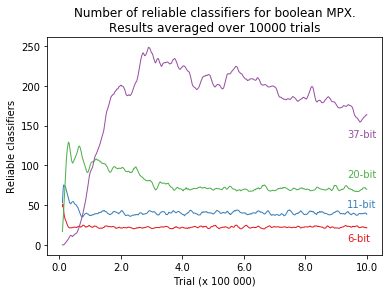

In [37]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

# To avoid Type3 fonts in generated EPS file
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

window=10_000
TOP_ROWS=1_000_000

def divider(x, pos):
    return x / 100_000

fig, ax = plt.subplots()

df6bit['reliable'].head(TOP_ROWS).rolling(window=window).mean().plot(color='#e41a1c', linewidth=1.0, ax=ax)
ax.text(935_000, 5, '6-bit', color='#e41a1c')

df11bit['reliable'].head(TOP_ROWS).rolling(window=window).mean().plot(color='#377eb8', linewidth=1.0, ax=ax)
ax.text(935_000, 47, '11-bit', color='#377eb8')

df20bit['reliable'].head(TOP_ROWS).rolling(window=window).mean().plot(color='#4daf4a', linewidth=1.0, ax=ax)
ax.text(935_000, 85, '20-bit', color='#4daf4a')

df37bit['reliable'].head(TOP_ROWS).rolling(window=window).mean().plot(color='#984ea3', linewidth=1.0, ax=ax)
ax.text(935_000, 135, '37-bit', color='#984ea3')

ax.set_xlabel('Trial (x 100 000)')
ax.set_ylabel('Reliable classifiers')
ax.xaxis.set_major_formatter(tkr.FuncFormatter(divider))
ax.set_title(f'Number of reliable classifiers for boolean MPX.\nResults averaged over {window} trials')
# plt.show()

plt.savefig('mpx.eps', format='eps', dpi=100)